# Evaluate LLM results

Install Dependencies

In [1]:
# %%capture
# !pip install datasets==2.20.0
# !pip install -U langsmith==0.1.99
# !pip install langchain_openai==0.1.22
# !pip install langchain==0.2.13
# !pip install langchain_community==0.2.12                          
# !pip install transformers==4.44.0
# !pip install termcolor==2.4.0
# !pip install accelerate==0.33.0
# !pip install pandas==2.2.2
# !pip install openpyxl==3.1.5
# !pip install python-dotenv==1.0.1
# !pip install einops==0.8.0
# !pip install wheel==0.44.0
# !pip install sentencepiece==0.2.0
# !pip install protobuf==5.27.3 #Mistral models needs this
# !pip install groq==0.10.0 #Groq models needs this
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2

# !pip install flash-attn==2.6.3 #Install it at the end after wheel has been installed
# !pip install anthropic==0.34.1 #Anthropic models needs this

# #Only if CPU is used
# !pip install torch==2.0.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import warnings
warnings.filterwarnings('ignore')

RunPod specific parameters

In [3]:
#For RunPod change to persistent storage directory
import os
os.chdir('/workspace')

Specify Path and Load API Keys

In [4]:
file_path ='/workspace/Example_QA_data_raw.xlsx' #Dataset generated with the help of GPT-4o - Has to be an excel file with 'input' and 'output' columns
#'/Users/nikolaossourlo/Desktop/Example_QA_data_raw.xlsx' #For MacOS
#'C:/Users/soyrl/Desktop/Example_QA_data_raw.xlsx' #For Windows
# '/content/drive/My Drive/Example_QA_data_raw.xlsx' #For Google Colab
#'/home/nikolaossourlo/Example_QA_data_raw.xlsx' #For Delft Blue
# '/workspace/Example_QA_data_raw.xlsx' #For RunPod

custom_cache_dir="/workspace/cache/huggingface" #Save models here so that we don't have to download them again
#"/scratch/nikolaossourlo/cache" in Delft Blue

# Check if custom_cache_dir is defined, otherwise use default behavior
try:
    cache_dir=custom_cache_dir
except:
    cache_dir=None

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv(dotenv_path=os.getcwd()+"/env")

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY_DRACO')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

#Login to Hugging Face
from huggingface_hub import login
# Log in with your Hugging Face token
login(token=os.getenv('HF_TOKEN'))

# print(openai_api_key)
# print(langsmith_api_key)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Select model and name for the experiment

In [5]:
#Model to generate responses to questions
models=[ 
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B-Instruct", #Takes 2.5-3mins in A4500 (20GB VRAM) and in Delft Blue (35min for 44Q&A pairs in V100 32GB)
    # "microsoft/Phi-3.5-mini-instruct", #Took 5mins in A40 with 48GB VRAM, 2mins in A4500 with 20GB VRAM, 3mins in Delft Blue (50min for 44Q&A pairs in V100 32GB)
    # "mistralai/Mistral-7B-Instruct-v0.3", #4mins in A40 with 48GB VRAM, 2.5mins in A4500 with 20GB VRAM and in Delft Blue
    # "Qwen/Qwen2-7B-Instruct", #4mins in A40 with 48GB VRAM, 2 mins in A4500 with 20GB VRAM, 2.5mins in Delft Blue
    # 'AI-MO/NuminaMath-7B-TIR', #2.5 in A4500 with 20GB VRAM and in Delft Blue - We can also try 01-ai/Yi-Coder-9B-Chat
    # 'microsoft/Phi-3-mini-4k-instruct', #6 mins in RTX3090
    # "google/gemma-2-9b-it", #More than 20GB of GPU memory needed - Works with A40 with 48GB VRAM (8mins), but not with A4500 - 20GB, and V100 - 32GB, 4.5mins in Delft Blue
    # 'mistralai/Mistral-Nemo-Instruct-2407', #12B parameters, 11mins in 2 RTX3090, 16mins in V100 with 32GB VRAM (48mins to run over all 44 Q&A pairs)
    # 'openai/gpt-4o-mini' #Costs very low ~0.01$ for 9 Q&A pairs.
    ] #All above models need ~130GB space, the last needs ~30GB . For 44 Q&A pairs it takes ~50min/model

# Groq models are defined as: groq_website/model_name e.g. 'groq_website/llama-3.1-70b-versatile'
# OpenAI models are defined as: 'openai/model_name', e.g. 'openai/gpt-4o-mini'
# Anthropic models are defined as 'anthropic/model_name', e.g. 'anthropic/claude-3-haiku-20240307' - Couldn't use due to billing issues

# I couldn't run 'nvidia/Mistral-NeMo-Minitron-8B-Base', "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4" (Conflicting dependencies),
# 'google/recurrentgemma-9b-it' # RecurrentGemmaForCausalLM.forward() got an unexpected keyword argument 'position_ids'

#Takes 6h for 25Q&A pairs with beam search (n=5) in V100 32GB (costs ~3$) for all models below (except Gemma) - Large models take more time (2min/generation for Mistral 12B)

#Define model to act as a judge
judge_model='openai/gpt-4o-mini' #If used with Llama, only 0.01$ for 9 Q&A pairs for gpt-4o-mini, and 0.22$ for gpt-4o

#Define maximum number of tokes in the judge LLM output
max_output_tokens=500

#Limit of tokens in the generated response from LLM
generate_max_tokens=1000

#Inference on whole dataset?
inference_on_whole_dataset=True

Define prompts for custom evaluation metrics

In [6]:
common_prompt="""
You are an autoregressive language model that acts as a judge in comparing a predicted vs an actual answer to a questions.
Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend 
a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question. 
Your users are experts in chemical engineering, so they already know you're a language model and your capabilities and limitations, so don't 
remind them of that. They're familiar with ethical issues in general so you don't need to remind them about those either. 
Don't be verbose in your answers, but do provide details and examples where it might help the explanation. 
""" #This is common for all prompts below

In [7]:
completeness_descr = """
Your task is to evaluate responses predicted by an LLM with regards to completeness compared to the completeness of a given actual, golden standard answer. 
The completeness metric evaluates the extent to which the user's question is answered in full in the predicted response. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: There is no response.
2: No parts of a suitable answer are present.
3: Few elements of a complete answer are present.
4: Most elements of a complete answer are present.
5: The response covers all elements of a complete answer.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

relevance_descr = """
Your task is to evaluate responses predicted by an LLM with regards to relevance compared to the relevance of a given actual, golden standard answer. 
The relevance metric evaluates the amount of irrelevant information in the predicted response considering the user's original question. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response answers something else, not the user's question.
2: The response answers the user's question but the information provided is mostly irrelevant.
3: The response answers the user's question but contains more irrelevant information than relevant information.
4: The response answers the user's question, and shares a bit of irrelevant information.
5: The response answers the user's question and contains no irrelevant information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

conciseness_descr = """
Your task is to evaluate responses predicted by an LLM with regards to conciseness compared to the conciseness of a given actual, golden standard answer. 
The conciseness metric evaluates the amount of unexpected extra information in the predicted response considering the user's original question. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response is too long and stops before completion or enters an infinite loop.
2: The response includes a lot of extra information and uses flowery language.
3: The response includes a lot of extra information or uses flowery language.
4: The response is short and includes a small amount of extra information.
4: The response is as short as possible while still answering the prompt.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

confidence_descr = """
Your task is to evaluate responses predicted by an LLM with regards to confidence compared to the confidence of a given actual, golden standard answer. 
The condifence metric evaluates the degree of assurance that is conveyed the response that the predicted answer is correct. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: Complete Rejection. The response makes it clear that the given answer is incorrect or that no correct answer can be provided.
2: Doubt and Disagreement. The response suggests that the answer is likely incorrect or raises significant concerns.
3: Uncertainty. The response indicates that the answer could be correct, but there is significant doubt or insufficient evidence.
4: Moderate Agreement. The response leans towards the answer being correct but acknowledges some uncertainty.
5: Full Endorsement. The reponse confidentely asserts that the given answer is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

factuality_descr = """
Your task is to evaluate responses predicted by an LLM with regards to factuality compared to the factuality of a given actual, golden standard answer.
 The factuality metric evaluates the degree of hallucination contained in a response or, in other words, how accurate a given response is.
You can assign a score from 1 to 5, with the following interpretations:
1: The response is a complete hallucination
2: The response is mostly a hallucination but does not change key information from the prompt (such as chemical identifiers).
3: The response contains large amounts of both hallucinations and factual information.
4: The response includes mostly factual information with slight hallucinations.
5: The response only includes factual information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

judgement_descr = """
Your task is to evaluate responses predicted by an LLM with regards to judgement compared to the judgement of a given actual, golden standard answer.
The judgment metric assesses how strongly the response implies its correctness, taking into account the actual accuracy of the answer.
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response confidently claims a hallucination as truth.
2: The response misinterprets information received in the prompt.
3: The response shows that the model is unsure about the answer or states that information is theoretical.
4: The response is wrong but it is made clear that the answer is wrong or that the model is unable to provide a correct answer.
5: The response is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

In [8]:
#How the dataset will be named in Langsmith
def get_dataset_name(model_name, judge_model):
    try: #For Hugging Face models
        return "Chemical_Engineering_Evaluation_"+model_name.split('/')[1]+'_with_judge_'+judge_model+'_beam_search_statistics'
    except: #For OpenAI models
        return "Chemical_Engineering_Evaluation_"+model_name+'_with_judge_'+judge_model+'_beam_search_statistics'

Check if GPU is available

In [9]:
import torch
print(torch.version.cuda)

12.1


Google Drive mount (If run in Colab)

In [10]:
if 'content/drive/My Drive' in file_path:
    from google.colab import drive
    drive.mount('/content/drive')

Read Excel File

In [11]:
import pandas as pd
qa=pd.read_excel(file_path) #Read Excel

Create Dataset from df

In [12]:
from datasets import Dataset
loaded_dataset=Dataset.from_pandas(qa)

if inference_on_whole_dataset==False:
    loaded_dataset = loaded_dataset.train_test_split(test_size=0.2, seed=42) #Used if going to fine-tune in part of the dataset

In [13]:
if inference_on_whole_dataset==False:
    dataset_train=loaded_dataset['train']
    dataset_test=loaded_dataset['test']
else:
    dataset_test=loaded_dataset #When we use the whole dataset

Create Langsmith Test Dataset

In [14]:
#https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets

from langsmith import Client

example_inputs = [(x['input'],x['output']) for x in dataset_test]
print(example_inputs)

def create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key):

    client = Client(api_key=langsmith_api_key)

    try:
        #Load the dataset if already exists
        for existing_dataset in client.list_datasets():
            if existing_dataset.name==dataset_name:
                dataset_langsmith=existing_dataset
        for x in dataset_langsmith:
            print("Dataset Loaded")
            break

    except: #Otherwise create it
        print("Dataset not found. Creating new dataset")
        # Storing inputs in a dataset lets us run chains and LLMs over a shared set of examples.
        dataset_langsmith = client.create_dataset(dataset_name=dataset_name,
                                                description="Q&A chemical engineering.")

        for input_prompt, output_answer in example_inputs:
            client.create_example(
                inputs={"question": input_prompt.replace('\n', ' ')},
                outputs={"answer": output_answer.replace('\n', ' ')},
                # metadata={"source": "Wikipedia"},
                dataset_id=dataset_langsmith.id,
            )

    return dataset_langsmith

[('What was the first appearance of process intensification in chemical engineering?', 'The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates.'), ('Give some examples of technologies used in process intesification.', 'Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors.')]


Custom Evaluation Metrics

In [15]:
# https://docs.smith.langchain.com/old/cookbook/introduction
# https://docs.smith.langchain.com/old/evaluation/faq/custom-evaluators
# https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-a-summary-evaluator

from langsmith.schemas import Run, Example
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from termcolor import colored

list_of_metrics=['completeness_descr','relevance_descr','conciseness_descr','confidence_descr','factuality_descr','judgement_descr']

#Function that compares the real answer with the predicted answer of an LLM and returns a score based on the evaluation
def factor_evaluator(run: Run, example: Example) -> dict: 
    # print("Run:",run)

    question=run.inputs.get("inputs")['question']
    # print("Question:",question)
    actual_answer = example.outputs.get("answer")
    # print("Real answer:",example.outputs.get("answer"))
    predicted_answer = run.outputs.get("output")
    # print("Predicted Answer:",answer)
    
    # Check if there is output from LLM
    if not predicted_answer:
        print("No output from LLM")
        return {"key": "custom_metric" , "score": 0} 
    
    else:
        scores={} #Store scores for each metric
        descriptions={} #Store descriptions for each metric
        
        for metric_name in list_of_metrics: #Iterate through all metrics
            print("Evaluating based on:",metric_name)
            metric_value=common_prompt+eval(metric_name) #Get the actual description of the metric

            # Define roles and placeholders
            chat_template = ChatPromptTemplate.from_messages(
            [("system", metric_value),
                ("user", "Question: {question}, Actual answer: {actual_answer}, Predicted answer: {predicted_answer}"),
                # ("ai", "It's sunny and warm outside."), #Use this if we want to use few shot prompts
            ]
            )

            messages = chat_template.format_messages(question=question, actual_answer=actual_answer, predicted_answer=predicted_answer)
            # print("Messages:",messages)

            formatted_messages = [(role, msg.content) for role, msg in zip(["system", "user"], messages)]
            # print("Formatted messages:",formatted_messages) #[('system', 'You are an autoregressive lan....', 'user':.....)]

            # Initialize the model and get response
            llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0, max_tokens=max_output_tokens, seed=42)
            ai_response = llm.invoke(formatted_messages)

            # Output
            # print(colored("System message:"+ messages[0].content,'blue'))
            print(colored("User message:"+ messages[1].content, 'green'))
            print(colored("AI message:"+ ai_response.content,'red'))

            #Decide what the final score is based on output
            if "FINAL SCORE:" in ai_response.content: 
                score = int(ai_response.content.split("FINAL SCORE:")[1])
            else:
                print("Invalid response from LLM:", ai_response.content)
                score = 0

            scores[metric_name]=score
            descriptions[metric_name]=ai_response.content
            print("Scores:",scores)
            print("\n")

    return {
        "results":[ #We always need 'key', 'score' pairs
            {"key": "completeness" , "score": scores['completeness_descr'],"value":descriptions['completeness_descr']},
            {"key": "relevance" , "score": scores['relevance_descr'], "value":descriptions['relevance_descr']},
            {"key": "conciseness" , "score": scores['conciseness_descr'], "value":descriptions['conciseness_descr']},
            {"key": "confidence" , "score": scores['confidence_descr'], "value":descriptions['confidence_descr']},
            {"key": "factuality" , "score": scores['factuality_descr'], "value":descriptions['factuality_descr']},
            {"key": "judgement" , "score": scores['judgement_descr'], "value":descriptions['judgement_descr']}
        ]
    }

Define Models that Generate Responses

In [16]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.random.manual_seed(0) #Set for reproducibility

def initialize_model(model_id):
    # # Check if mps acceleration is available (For MacOS)
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    # print(f"Using device {device}")
    # model.to(device)

    # transformers.set_seed(42) #Tried for reproducibility but didn't work
    
    pipeline = transformers.pipeline( 
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir":cache_dir},
            # trust_remote_code=True,
            device_map="auto" #Use 'cuda' if one GPU available (works in Delft Blue with 32GB VRAM) - 'auto' the alternative for distributed over all available GPUs
        )
    return pipeline

def get_model(model_id):
    """Given a model name, return the loaded model, tokenizer, and pipeline"""

    if 'openai' not in model_id and 'groq_website' not in model_id: #For Hugging Face models
        pipeline=initialize_model(model_id)

    #Returns below variables if defined, and returns None for any that are not.
    model = locals().get('model', None)
    tokenizer = locals().get('tokenizer', None)
    pipeline = locals().get('pipeline', None)

    return model, tokenizer, pipeline

Generate Responses

In [17]:
import time

def predict(inputs: dict) -> dict:
    """Given a question, return the answer from the model"""
    
    #Get these variables from the global scope
    global model_name
    
    messages = [ #Only use the questions to ask the model to generate the response
      {"role": "user", "content": inputs['question']},
    ]

    if 'gemma' not in model_name: #Gemma doesn't support system message
      messages.insert(0, {"role": "system", "content": "You are a language model specialized in chemical engineering. Answer the following question:"})
    else: #For gemma add system prompt in user message
      messages[0]['content']="You are a language model specialized in chemical engineering. Answer the following question: " + messages[0]['content']
    # print("Prompt:",messages)

    generation_args = { 
        "max_new_tokens": max_output_tokens, 
        "return_full_text": False, 
        "temperature": 0.1, # 1e-8,  #Has to be positive number - not considered from model when do_sample is False (reproducible results)
        "do_sample": True, #Selects highest probability token if sets to False
        "num_beams" : 5, #3 can also work if computationally intensive - more info on https://huggingface.co/blog/how-to-generate
        #Warnings will be raised by some models

        #If we only set temp!=0 or if we also set do_sample=False then warning: `do_sample` is set to `False`. However, `temperature` is set to `1e-08` 
        # -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
        # That means that the temperature is probably ignored
        # Sometimes, results not reproducible if only temp is set
      } 
    
    if 'openai' not in model_name and 'groq_website' not in model_name: #For Hugging Face models
      response=pipeline(messages, **generation_args)[0]['generated_text']
      print(model_name,':',response)

    else: 
      if 'openai' in model_name:
        try:
          import openai
          from langsmith.wrappers import wrap_openai
                  
          # Define OpenAI client
          openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
          
          response = openai_client.chat.completions.create(messages=messages, temperature=0, model=model_name.split('/')[1],  seed=42) 
          # print("Response:",response.choices[0].message.content)
          response=response.choices[0].message.content #That's the response without formatting
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("OpenAI Model ID:",model_name)

      elif 'groq_website' in model_name:
        try:
          from groq import Groq
          client = Groq()
          actual_model_name=model_name.split('/')[1]
          response = client.chat.completions.create(
              model=actual_model_name,
              max_tokens=generate_max_tokens,
              temperature=0,
              messages=messages)
          # print("Response from Groq:",response.choices[0].message.content)
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("Groq Model ID:",model_name)

    return {"output": response}

In [18]:
def plot_figures_metrics(metric_names, metric_values, model_name, judge_model):
    #Plot figures with distributions of metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy.stats import t

    # Colors for separate plots
    colors = sns.color_palette("Set3", len(metric_names))

    # Create two figures - one with separate subplots and one overlaid
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 18))
    fig_overlay, ax_overlay = plt.subplots(figsize=(10, 6))
    
    plt.subplots_adjust(hspace=0.6, top=0.94)

    # Set titles
    fig.suptitle(f'Metric Distributions for {model_name}', fontsize=16)
    fig_overlay.suptitle(f'Overlaid Metric Distributions for {model_name}', fontsize=16)

    # Define the bin edges explicitly to ensure consistency
    bin_edges = np.arange(0.0, 5.6, 0.2)  # Adjust to cover the range 1-5 with bins of width 1

    #Summary statistics
    summary_stats={}

    print("metric_names",metric_names)
    print("metric_values",metric_values)
    # Plotting each metric in separate subplots and overlay plot
    for i, (metric_name, values) in enumerate(zip(metric_names, metric_values)):

        print("metric_name",metric_name)
        print("values",values)

        mean_value=np.mean(values) #Mean of the metric
        print("mean_values",mean_value)
        std_errors=np.std(values)/np.sqrt(len(values))
        print("std_errors",std_errors)
        print([x for x in values])

        # Plot on individual subplot
        sns.histplot(values, bins=bin_edges, color=colors[i], ax=axes[i], kde=False)
        
        # Plot on overlay plot with transparency
        sns.histplot(values, bins=bin_edges, color=colors[i], ax=ax_overlay, kde=False, 
                    alpha=0.5, label=metric_name)
        
        # Add confidence intervals for individual plots
        n = len([data for data in values])
        print("n",n)
        t_critical = t.ppf(0.975, df=n-1)
        print("t_critical",t_critical)
        margin_of_error = t_critical * std_errors
        print("margin_of_error",margin_of_error)
        ci_low = mean_value - margin_of_error
        ci_high = mean_value + margin_of_error
        print("ci_low",ci_low)
        print("ci_high",ci_high)

        # Add error bar to show confidence interval on individual plots
        axes[i].errorbar(mean_value, axes[i].get_ylim()[1]/2, 
                        xerr=margin_of_error,
                        color='black',
                        capsize=5,
                        capthick=1,
                        elinewidth=2,
                        marker='o')

        summary_stats[metric_name]={"mean":mean_value,"std_error":std_errors,"ci_low":ci_low,"ci_high":ci_high}
        axes[i].set_title(f'{metric_name} (Mean: {np.mean(mean_value):.2f} ± {np.mean(std_errors):.2f} SE, CI: {ci_low:.2f}-{ci_high:.2f})')
        axes[i].set_xlim(0, 5.5) #Keep 0 in case of errors
        axes[i].set_ylabel('Frequency')
        axes[i].set_yticks(range(0, 11, 5)) #Set y-ticks at intervals of 5
        # axes[i].legend()

        # Hide x-axis labels and ticks for all but the last subplot
        if i < len(metric_names) - 1:
            axes[i].set_xlabel('')
        else:
            axes[i].set_xlabel('Values')

    # Configure overlay plot
    ax_overlay.set_xlabel('Values')
    ax_overlay.set_ylabel('Frequency')
    ax_overlay.set_xlim(0, 5.5)
    ax_overlay.legend()

    # Save both plots
    plt.figure(fig.number)
    plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_metric_distributions.png')
    
    plt.figure(fig_overlay.number)
    plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_metric_distributions_overlay.png')
    
    plt.close('all')

        # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    for metric, stats in summary_stats.items():
        print(f"{metric}:")
        print(f"  Mean: {stats['mean']:.2f}")
        print(f"  Standard Error: {stats['std_error']:.2f}")
        print(f"  CI: {stats['ci_low']:.2f}-{stats['ci_high']:.2f}")
        print("-" * 50)

    return summary_stats, metric_names, metric_values

Perform the Evaluation over all models

In [19]:
#https://python.langchain.com/v0.2/docs/integrations/chat/openai/
from langsmith.evaluation import evaluate

# Keep track of all model stats
all_model_stats = {}

metrics_models={}

all_runs_model_metrics={}

#Initialize models
for model_id in models:
    
    dataset_name=get_dataset_name(model_id, judge_model) #How the dataset will be named in Langsmith
    dataset_langsmith=create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key)
    model, tokenizer, pipeline = get_model(model_id)
    print(f"\nEvaluating model: {model_id}")
    model_name=model_id #Since model_name defined as global variable

    # Evaluation
    begin=time.time()
    n_resamples=5
    all_evaluation_results=[]

    for i in range(n_resamples):
        print(f"\nPerforming evaluation resample {i+1}/{n_resamples}")
   
        evaluation_results=evaluate(
            predict, #Function that call our LLM and returns its output
            data=dataset_langsmith.name, #Just using dataset_langsmith doesn't work 
            evaluators=[factor_evaluator], #Evaluators to use
            # metadata={"revision_id": "the version of your pipeline you are testing"},
            experiment_prefix=str(judge_model)+'_judge_with_'+str(model_id)+'_resample_'+str(i) # A prefix for your experiment names to easily identify them
        )

        all_evaluation_results.extend(evaluation_results)

    end=time.time()
    print("Total time taken:",end-begin)

    chunk_size = len(example_inputs) #Number of questions

    try: #Sometimes some errors with 1+ Q&A missing

        #Extract metrics and save to df
        #Initialize empty df to be filled with results
        results_df=pd.DataFrame()

        #https://docs.smith.langchain.com/tutorials/Developers/evaluation
        # Get unique questions/answers (take only first resample since they're repeated)
        unique_results = all_evaluation_results[:chunk_size]
        print("unique_results",unique_results)
        list_of_questions = [x['example'].inputs['question'] for x in unique_results]
        list_of_answers = [x['example'].outputs['answer'] for x in unique_results]
        print("list_of_questions",list_of_questions)
        print("list_of_answers",list_of_answers)

        # Add base columns
        results_df['questions'] = list_of_questions
        results_df['answers'] = list_of_answers

        all_metrics=[]

        all_runs_metric_scores=[]
        # Create columns for each resample's predicted answers and metrics
        for i in range(n_resamples):
            start_idx = i * chunk_size
            resample_results = all_evaluation_results[start_idx:start_idx + chunk_size]
            predicted_answers = [x['run'].outputs['output'] for x in resample_results]
            metrics = [x['evaluation_results']['results'] for x in resample_results if x['run'].outputs['output'] is not None] #CONDITION COPIED FROM BELOW
            
            # Add predicted answers and metrics side by side
            results_df[f'predicted_answer_{i+1}'] = predicted_answers

        # # Process metrics for each resample
        #     metrics = [x['evaluation_results']['results'] for x in resample_results if x['run'].outputs['output'] is not None]
            all_metrics.append(metrics) #[resamples[questions[metrics]]]
            print("len(all_metrics)",len(all_metrics))
            print("all_metrics",all_metrics)

            individual_run_metric_scores={}

            # Add metrics and evaluation prompts with their corresponding predicted answers
            for metric_idx, metric_name in enumerate(list_of_metrics):
                print("metric_name",metric_name)
                metric_scores = [m[metric_idx].score for m in metrics] #Scores of a given metric over all question for a given resample
                print("metric_scores",metric_scores)
                metric_prompts = [m[metric_idx].value for m in metrics]
                print("metric_prompts",metric_prompts)
                results_df[f'metric_{metric_name}_{i+1}'] = metric_scores
                results_df[f'prompt_{metric_name}_{i+1}'] = metric_prompts
                # results_df[f'predicted_answer_for_{metric_name}_{i+1}'] = predicted_answers
                individual_run_metric_scores[metric_name]=metric_scores #Keep track of scores of a given metric over all questions for all resamples - len should be 5*

            all_runs_metric_scores.append(individual_run_metric_scores)

        all_runs_model_metrics[model_id]=all_runs_metric_scores
        print("all_runs_model_metrics",all_runs_model_metrics)



        try:
            # Handle NaN values across all resamples
            nan_rows = []
            for i in range(n_resamples):
                for metric in list_of_metrics:
                    metric_col = f'metric_{metric}_{i+1}'
                    nan_indices = results_df[metric_col].isna()
                    if nan_indices.any():
                        for idx in nan_indices[nan_indices].index:
                            print(colored(f"Missing value for metric '{metric}' in resample {i+1}", 'red'))
                            print(colored(f"Question: {results_df.loc[idx, 'questions']}", 'green'))
                            nan_rows.append(idx)
            
            nan_rows = list(set(nan_rows))  # Get unique indices
            if nan_rows:
                print(colored(f"ERROR: Found NaN values in {len(nan_rows)} rows out of {len(results_df)}", 'red'))
                print(colored(f"Row indices with NaN: {nan_rows}", 'green'))
                # results_df = results_df.drop(nan_rows) #Do not drop now since resampling - USE nanmean instead!
        except Exception as e:
            print(colored(f"Error handling NaN values: {str(e)}", 'red'))

        # Save results before processing metrics
        results_df.to_excel(f"results_{judge_model.split('/')[1]}_judge_with_{model_id.replace('/','_')}.xlsx", index=False)
        print("results_df saved")

        # Process metrics for each resample
        # all_metrics = []
        # for i in range(n_resamples):
        #     start_idx = i * chunk_size
        #     resample_results = all_evaluation_results[start_idx:start_idx + chunk_size]
        #     metrics = [x['evaluation_results']['results'] for x in resample_results if x['run'].outputs['output'] is not None]
        #     all_metrics.append(metrics)
        # print("all_metrics",all_metrics)

        # Reorganize metrics by type
        metric_stats = {metric.replace('_descr', ''): [] for metric in list_of_metrics}
        # print("metric_stats",metric_stats) #This is empty
        
        for metric_name in list_of_metrics:
            clean_name = metric_name.replace('_descr', '')
            for resample_metrics in all_metrics:
                scores = [m[list_of_metrics.index(metric_name)].score for m in resample_metrics]
                print("scores",scores)
                metric_stats[clean_name].extend(scores)
                print("metric_stats",metric_stats)

        print("metric_statsnew",metric_stats)

        # Create final metric names and values for plotting
        metric_names = list(metric_stats.keys())
        metric_values = [metric_stats[name] for name in metric_names]
        print("metric_names",metric_names)
        print("metric_values",metric_values)

        # Store summary stats for this model
        all_model_stats[model_id], metric_names, metric_values = plot_figures_metrics(
            metric_names, 
            metric_values, 
            model_id, 
            judge_model
        )
        print("all_model_stats",all_model_stats)
        

        metrics_models[model_id]=all_metrics
       


    #    #DEL
    #     all_runs_metrics=[x['evaluation_results']['results'] for ind,x in enumerate(evaluation_results)]# if ind not in indices_to_drop] #list of lists with metric names
    #     print("all_runs_metrics",all_runs_metrics)
    #     all_metric_values=[[{x[i].key: x[i].score} for x in all_runs_metrics] for i in range(len(list_of_metrics))] #List of all completeness scores
    #     print("all_metric_values",all_metric_values)


    #     metric_names=[key for i in range(len(all_metric_values)) for key in all_metric_values[i][0].keys()]
    #     print("metric_names",metric_names)
    #     metric_values=[[list(x.values())[0] for x in all_metric_values[i]] for i in range(len(all_metric_values))]
    #     print("metric_values",metric_values)
        
    #     all_metric_prompts=[[{x[i].key:x[i].value} for x in all_runs_metrics] for i in range(len(list_of_metrics))]
    #     metric_prompts=[[list(x.values())[0] for x in all_metric_prompts[i]] for i in range(len(all_metric_prompts))]

    #     # Adding columns to DataFrame
    #     results_df=pd.DataFrame()
    #     for col_name, col_values,col_prompts in zip(metric_names, metric_values,metric_prompts):
    #         results_df[col_name] = col_values
    #         results_df[col_name+'_prompt'] = col_prompts

    #     #Save results to Excel
    #     results_df.to_excel("resultstest_"+str(judge_model.split('/')[1])+'_judge_with_'+str(model_id).replace("/","_")+".xlsx",index=False)






        # #Plot figures with distributions of metrics
        # # Store the summary stats for this model
        # all_model_stats[model_id], metric_names, metric_values = plot_figures_metrics(metric_names, metric_values, model_id, judge_model)

    except Exception as e:
        print("An error occur in plotting metrics")
        print(e)

    # Clear VRAM at the end of each iteration
    del model, tokenizer, pipeline
    torch.cuda.empty_cache()

    print('-'*100)

Dataset Loaded


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]



Evaluating model: meta-llama/Llama-3.2-3B-Instruct

Performing evaluation resample 1/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Llama-3.2-3B-Instruct_resample_0-e67ad734' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/f664808e-1532-431c-bced-cb5ab52adf83/compare?selectedSessions=b9a5452e-1056-45cc-9df8-7ea9028b7380




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Llama-3.2-3B-Instruct : The concept of process intensification in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself is a relatively recent development.

One of the earliest examples of process intensification can be found in the work of Fritz Haber, a German chemist and Nobel laureate, in the early 1900s. Haber developed the Haber-Bosch process, which is a highly efficient method for synthesizing ammonia (NH3) from nitrogen (N2) and hydrogen (H2) gases. This process, which was first commercialized in the 1910s, is considered one of the first examples of process intensification in chemical engineering.

In the 1950s and 1960s, the concept of process intensification began to gain more attention in the field of chemical engineering. This was largely driven by the need to improve the efficiency and productivity of chemical processes, particularly in the context of the petroleum and petrochemical industries.

However,

2it [01:08, 34.49s/it]



Performing evaluation resample 2/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Llama-3.2-3B-Instruct_resample_1-4fcbea93' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/f664808e-1532-431c-bced-cb5ab52adf83/compare?selectedSessions=b83bc2a8-a0e6-461c-a424-641604b6aa99




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Llama-3.2-3B-Instruct : The concept of process intensification in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself is a relatively recent development.

One of the earliest examples of process intensification can be found in the work of Fritz Haber, a German chemist and Nobel laureate, in the early 1900s. Haber developed the Haber-Bosch process, which is a highly efficient method for synthesizing ammonia (NH3) from nitrogen (N2) and hydrogen (H2) gases. This process, which was first commercialized in the 1910s, is considered one of the first examples of process intensification in chemical engineering.

In the 1950s and 1960s, the concept of process intensification began to gain more attention in the field of chemical engineering. This was largely driven by the need to improve the efficiency and productivity of chemical processes, particularly in the context of the petroleum and petrochemical industries.

However,

2it [00:56, 28.11s/it]



Performing evaluation resample 3/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Llama-3.2-3B-Instruct_resample_2-a80f4856' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/f664808e-1532-431c-bced-cb5ab52adf83/compare?selectedSessions=7fe3d402-a429-4e0f-8db6-480d7e61ed12




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Llama-3.2-3B-Instruct : The concept of process intensification in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself is a relatively recent development.

One of the earliest examples of process intensification can be found in the work of Fritz Haber, a German chemist and Nobel laureate, in the early 1900s. Haber developed the Haber-Bosch process, which is a highly efficient method for synthesizing ammonia (NH3) from nitrogen (N2) and hydrogen (H2) gases. This process, which was first commercialized in the 1910s, is considered one of the first examples of process intensification in chemical engineering.

In the 1950s and 1960s, the concept of process intensification began to gain more attention in the field of chemical engineering. This was largely driven by the need to improve the efficiency and productivity of chemical processes, particularly in the context of the petroleum and petrochemical industries.

However,

2it [00:56, 28.09s/it]



Performing evaluation resample 4/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Llama-3.2-3B-Instruct_resample_3-0dba31ed' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/f664808e-1532-431c-bced-cb5ab52adf83/compare?selectedSessions=b4a6d222-7ba8-4da3-8956-d6ca23f4af6b




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Llama-3.2-3B-Instruct : The concept of process intensification in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself is a relatively recent development.

One of the earliest examples of process intensification can be found in the work of Fritz Haber, a German chemist and Nobel laureate, in the early 1900s. Haber developed the Haber-Bosch process, which is a highly efficient method for synthesizing ammonia (NH3) from nitrogen (N2) and hydrogen (H2) gases. This process, which was first commercialized in the 1910s, is considered one of the first examples of process intensification in chemical engineering.

In the 1950s and 1960s, the concept of process intensification began to gain more attention in the field of chemical engineering. This was largely driven by the need to improve the efficiency and productivity of chemical processes, particularly in the context of the petroleum and petrochemical industries.

However,

2it [01:09, 34.63s/it]



Performing evaluation resample 5/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Llama-3.2-3B-Instruct_resample_4-8e1998f3' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/f664808e-1532-431c-bced-cb5ab52adf83/compare?selectedSessions=2526de21-e323-4fb3-a426-097aa8b94875




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Llama-3.2-3B-Instruct : The concept of process intensification in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself is a relatively recent development.

One of the earliest examples of process intensification can be found in the work of Fritz Haber, a German chemist and Nobel laureate, in the early 1900s. Haber developed the Haber-Bosch process, which is a highly efficient method for synthesizing ammonia (NH3) from nitrogen (N2) and hydrogen (H2) gases. This process, which was first commercialized in the 1910s, is considered one of the first examples of process intensification in chemical engineering.

In the 1950s and 1960s, the concept of process intensification began to gain more attention in the field of chemical engineering. This was largely driven by the need to improve the efficiency and productivity of chemical processes, particularly in the context of the petroleum and petrochemical industries.

However,

2it [01:06, 33.43s/it]


Total time taken: 332.729398727417
unique_results [{'run': RunTree(id=UUID('429563b0-cd51-4c23-91ee-50fa06c21909'), name='Target', start_time=datetime.datetime(2024, 11, 29, 14, 47, 0, 729158, tzinfo=datetime.timezone.utc), run_type='chain', end_time=datetime.datetime(2024, 11, 29, 14, 47, 20, 657266, tzinfo=datetime.timezone.utc), extra={'metadata': {'revision_id': None, 'num_repetitions': 1, 'example_version': '2024-11-28T15:29:19.763288+00:00', 'ls_method': 'traceable'}, 'runtime': {'sdk': 'langsmith-py', 'sdk_version': '0.1.99', 'library': 'langsmith', 'platform': 'Linux-6.5.0-44-generic-x86_64-with-glibc2.35', 'runtime': 'python', 'py_implementation': 'CPython', 'runtime_version': '3.10.12', 'langchain_version': '0.2.13', 'langchain_core_version': '0.2.38', 'thread_count': 40.0, 'mem': {'rss': 1507581952.0}, 'cpu': {'time': {'sys': 3.29, 'user': 26.57}, 'ctx_switches': {'voluntary': 1051.0, 'involuntary': 59.0}, 'percent': 0.0}}}, error=None, serialized={'name': 'Target', 'signatu

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]



Evaluating model: meta-llama/Meta-Llama-3.1-8B-Instruct

Performing evaluation resample 1/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_0-83f8d107' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/d47423d8-85ac-40f5-938e-592819891332/compare?selectedSessions=fa51e01e-aad4-419a-b0d3-4fdee1b522fa




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Meta-Llama-3.1-8B-Instruct : The concept of process intensification (PI) in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself was first coined in the 1980s.

One of the earliest examples of process intensification can be attributed to the work of Nobel laureate Fritz Haber in the early 20th century. Haber developed the Haber-Bosch process for ammonia synthesis, which is a prime example of process intensification. The Haber-Bosch process involves the reaction of nitrogen and hydrogen at high temperatures and pressures to produce ammonia. This process was a significant innovation at the time, as it allowed for the large-scale production of ammonia, which is a critical component in the production of fertilizers.

Another early example of process intensification can be seen in the development of the catalytic reforming process for the production of high-octane gasoline. This process, which was developed in the 1940s 

2it [01:17, 38.79s/it]



Performing evaluation resample 2/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_1-6c90129a' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/d47423d8-85ac-40f5-938e-592819891332/compare?selectedSessions=d52a6b4c-2338-4970-ba13-3189fef12679




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Meta-Llama-3.1-8B-Instruct : The concept of process intensification (PI) in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself was first coined in the 1980s.

One of the earliest examples of process intensification can be attributed to the work of Nobel laureate Fritz Haber in the early 20th century. Haber developed the Haber-Bosch process for ammonia synthesis, which is a prime example of process intensification. The Haber-Bosch process involves the reaction of nitrogen and hydrogen at high temperatures and pressures to produce ammonia. This process was a significant innovation at the time, as it allowed for the large-scale production of ammonia, which is a critical component in the production of fertilizers.

Another early example of process intensification can be seen in the development of the catalytic reforming process for the production of high-octane gasoline. This process, which was developed in the 1940s 

2it [01:17, 38.54s/it]



Performing evaluation resample 3/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_2-01d023e3' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/d47423d8-85ac-40f5-938e-592819891332/compare?selectedSessions=c6fa42dd-2ede-478a-93b0-0e2678c9df68




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Meta-Llama-3.1-8B-Instruct : The concept of process intensification (PI) in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself was first coined in the 1980s.

One of the earliest examples of process intensification can be attributed to the work of Nobel laureate Fritz Haber in the early 20th century. Haber developed the Haber-Bosch process for ammonia synthesis, which is a prime example of process intensification. The Haber-Bosch process involves the reaction of nitrogen and hydrogen at high temperatures and pressures to produce ammonia. This process was a significant innovation at the time, as it allowed for the large-scale production of ammonia, which is a critical component in the production of fertilizers.

Another early example of process intensification can be seen in the development of the catalytic reforming process for the production of high-octane gasoline. This process, which was developed in the 1940s 

2it [01:30, 45.05s/it]



Performing evaluation resample 4/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_3-de94e7a4' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/d47423d8-85ac-40f5-938e-592819891332/compare?selectedSessions=167e7a3a-ab7e-4c76-a455-5c64c810568a




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Meta-Llama-3.1-8B-Instruct : The concept of process intensification (PI) in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself was first coined in the 1990s.

One of the earliest examples of process intensification can be attributed to the work of Nobel laureate Fritz Haber in the early 20th century. Haber developed the Haber-Bosch process for ammonia synthesis, which is a prime example of process intensification. The Haber-Bosch process involves the reaction of nitrogen and hydrogen to produce ammonia at high pressures and temperatures, resulting in a significant increase in reaction rate and yield.

Another early example of process intensification can be seen in the work of Eugene Houdry, who developed the Houdry process for catalytic cracking of petroleum in the 1930s. This process involved the use of a fluidized bed reactor, which allowed for a significant increase in reaction rate and yield compared to tradit

2it [01:13, 36.62s/it]



Performing evaluation resample 5/5
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_4-f8b288ea' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/d47423d8-85ac-40f5-938e-592819891332/compare?selectedSessions=9d6b90e3-873f-4606-984d-e4eb671728ec




0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


meta-llama/Meta-Llama-3.1-8B-Instruct : The concept of process intensification (PI) in chemical engineering has its roots in the early 20th century. However, the term "process intensification" itself was first coined in the 1980s.

One of the earliest examples of process intensification can be attributed to the work of Wilhelm Ostwald, a Nobel laureate in chemistry, in the early 20th century. Ostwald's work on catalytic reactions and his development of the Ostwald process for the production of nitric acid in the early 1900s can be seen as an early form of process intensification.

Another notable example is the work of Fritz Haber and Carl Bosch, who developed the Haber-Bosch process for the production of ammonia in the early 20th century. This process, which involves the reaction of nitrogen and hydrogen to produce ammonia, is a classic example of process intensification, as it involves the use of high-pressure and high-temperature conditions to increase the reaction rate and yield.



2it [01:09, 34.78s/it]


Total time taken: 400.0416898727417
unique_results [{'run': RunTree(id=UUID('cd2f578f-c4ce-442c-98e4-935ac610043b'), name='Target', start_time=datetime.datetime(2024, 11, 29, 14, 52, 39, 870942, tzinfo=datetime.timezone.utc), run_type='chain', end_time=datetime.datetime(2024, 11, 29, 14, 53, 14, 918739, tzinfo=datetime.timezone.utc), extra={'metadata': {'revision_id': None, 'num_repetitions': 1, 'example_version': '2024-11-28T15:35:18.703305+00:00', 'ls_method': 'traceable'}, 'runtime': {'sdk': 'langsmith-py', 'sdk_version': '0.1.99', 'library': 'langsmith', 'platform': 'Linux-6.5.0-44-generic-x86_64-with-glibc2.35', 'runtime': 'python', 'py_implementation': 'CPython', 'runtime_version': '3.10.12', 'langchain_version': '0.2.13', 'langchain_core_version': '0.2.38', 'thread_count': 61.0, 'mem': {'rss': 1729331200.0}, 'cpu': {'time': {'sys': 19.62, 'user': 167.34}, 'ctx_switches': {'voluntary': 1674.0, 'involuntary': 87.0}, 'percent': 0.0}}}, error=None, serialized={'name': 'Target', 'sig

Statistical comparison between models

In [37]:
# Add this after the evaluation loop to print final comparison
def print_final_comparison(all_model_stats):
    print("\nFinal Comparison Across All Models:")
    print("=" * 80)
    
    # Get all metrics from first model (assuming all models have same metrics)
    if not all_model_stats:
        print("No statistics available")
        return
        
    metrics = list(next(iter(all_model_stats.values())).keys())
    
    for metric in metrics:
        print(f"\n{metric.upper()}:")
        print("-" * 40)
        for model, stats in all_model_stats.items():
            model_name = model.split('/')[-1]  # Get just the model name without path
            mean = stats[metric]['mean']
            se = stats[metric]['std_error']
            # Calculate 95% confidence interval
            ci_lower = mean - 1.96 * se
            ci_upper = mean + 1.96 * se
            print(f"{model_name:30} {mean:.2f} ± {se:.2f} (95% CI: [{ci_lower:.2f}, {ci_upper:.2f}])")

# Print the final comparison
print_final_comparison(all_model_stats)


Final Comparison Across All Models:

COMPLETENESS:
----------------------------------------
Llama-3.2-3B-Instruct          3.50 ± 0.16 (95% CI: [3.19, 3.81])
Meta-Llama-3.1-8B-Instruct     3.70 ± 0.25 (95% CI: [3.22, 4.18])

RELEVANCE:
----------------------------------------
Llama-3.2-3B-Instruct          3.10 ± 0.09 (95% CI: [2.91, 3.29])
Meta-Llama-3.1-8B-Instruct     3.50 ± 0.16 (95% CI: [3.19, 3.81])

CONCISENESS:
----------------------------------------
Llama-3.2-3B-Instruct          3.00 ± 0.00 (95% CI: [3.00, 3.00])
Meta-Llama-3.1-8B-Instruct     3.00 ± 0.00 (95% CI: [3.00, 3.00])

CONFIDENCE:
----------------------------------------
Llama-3.2-3B-Instruct          3.70 ± 0.25 (95% CI: [3.22, 4.18])
Meta-Llama-3.1-8B-Instruct     4.00 ± 0.32 (95% CI: [3.38, 4.62])

FACTUALITY:
----------------------------------------
Llama-3.2-3B-Instruct          3.40 ± 0.15 (95% CI: [3.10, 3.70])
Meta-Llama-3.1-8B-Instruct     3.80 ± 0.28 (95% CI: [3.26, 4.34])

JUDGEMENT:
-------------------

In [38]:
import itertools
import numpy as np
from scipy import stats

def compare_models(all_results, alpha=0.05):
    """
    Performs statistical comparison between all model pairs.
    
    Args:
        all_results (list): List of evaluation results for each run
        alpha (float): Significance level for statistical tests
    
    Returns:
        dict: Dictionary containing pairwise comparison results
    """
    # Extract model names and scores from the evaluation results
    results_by_model = {}
    for result in all_results:
        # Get model name from the session name - handle case where 'with' is incorrectly extracted
        model_name = result['run'].session_name
        # Extract the full model name, not just a part
        if model_name not in results_by_model:
            results_by_model[model_name] = []
            
        # Extract scores from evaluation results
        for eval_result in result['evaluation_results']['results']:
            results_by_model[model_name].append({
                'metric': eval_result.key,
                'score': eval_result.score
            })
    print("results_by_model",results_by_model)
    
    # Ensure we have at least 2 models to compare
    if len(results_by_model.keys()) < 2:
        print("Warning: Need at least 2 models to compare. Check session naming convention.")
        return {}
        
    model_pairs = list(itertools.combinations(results_by_model.keys(), 2))
    print("model_pairs",model_pairs)
    comparison_results = {}
    
    for model1, model2 in model_pairs:
        comparison_results[f"{model1}_vs_{model2}"] = {}
        
        # Get all unique metrics
        metrics = set(r['metric'] for r in results_by_model[model1] + results_by_model[model2])
        
        for metric in metrics:
            # Get scores for both models for this metric
            scores1 = [r['score'] for r in results_by_model[model1] if r['metric'] == metric]
            scores2 = [r['score'] for r in results_by_model[model2] if r['metric'] == metric]
            
            if not scores1 or not scores2:
                continue
                
            # Perform t-test
            t_stat, p_value = stats.ttest_ind(scores1, scores2)
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
            effect_size = (np.mean(scores1) - np.mean(scores2)) / pooled_std
            
            comparison_results[f"{model1}_vs_{model2}"][metric] = {
                "t_statistic": t_stat,
                "p_value": p_value,
                "effect_size": effect_size,
                "significant": p_value < alpha,
                "better_model": model1 if np.mean(scores1) > np.mean(scores2) else model2
            }
    
    return comparison_results

In [39]:
# Perform model comparisons
comparison_results = compare_models(all_evaluation_results)

# Print comparison results
print("\nModel Comparison Results:")
for comparison, metrics in comparison_results.items():
    print(f"\n{comparison}:")
    for metric, results in metrics.items():
        print(f"\n{metric}:")
        print(f"  Better model: {results['better_model']}")
        print(f"  Effect size: {results['effect_size']:.3f}")
        print(f"  P-value: {results['p_value']:.3f}")
        print(f"  Significant: {results['significant']}")

results_by_model {'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_0-83f8d107': [{'metric': 'completeness', 'score': 4}, {'metric': 'relevance', 'score': 4}, {'metric': 'conciseness', 'score': 3}, {'metric': 'confidence', 'score': 5}, {'metric': 'factuality', 'score': 5}, {'metric': 'judgement', 'score': 5}, {'metric': 'completeness', 'score': 3}, {'metric': 'relevance', 'score': 3}, {'metric': 'conciseness', 'score': 3}, {'metric': 'confidence', 'score': 3}, {'metric': 'factuality', 'score': 3}, {'metric': 'judgement', 'score': 2}], 'openai/gpt-4o-mini_judge_with_meta-llama/Meta-Llama-3.1-8B-Instruct_resample_1-6c90129a': [{'metric': 'completeness', 'score': 5}, {'metric': 'relevance', 'score': 4}, {'metric': 'conciseness', 'score': 3}, {'metric': 'confidence', 'score': 5}, {'metric': 'factuality', 'score': 4}, {'metric': 'judgement', 'score': 3}, {'metric': 'completeness', 'score': 3}, {'metric': 'relevance', 'score': 3}, {'metric': 'conciseness', 'score'

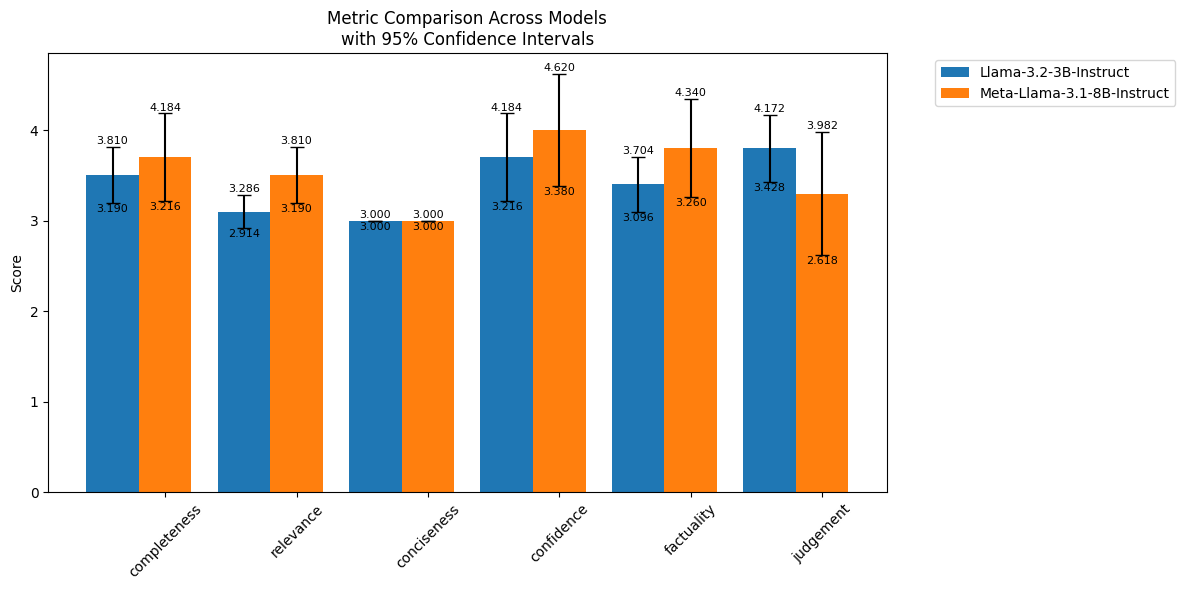

In [31]:
# Optionally, create a visualization of the comparison
def plot_final_comparison(all_model_stats):
    import matplotlib.pyplot as plt
    import numpy as np
    
    if not all_model_stats:
        return
        
    metrics = list(next(iter(all_model_stats.values())).keys())
    models = list(all_model_stats.keys())
    n_metrics = len(metrics)
    n_models = len(models)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(n_metrics)
    width = 0.8 / n_models
    
    for i, model in enumerate(models):
        means = [all_model_stats[model][metric]['mean'] for metric in metrics]
        errs = [all_model_stats[model][metric]['std_error'] for metric in metrics]
        
        # Calculate 95% confidence intervals
        conf_intervals = []
        for mean, err in zip(means, errs):
            # For 95% CI, multiply standard error by 1.96
            conf_interval = 1.96 * err
            conf_intervals.append(conf_interval)
        
        ax.bar(x + i*width - width*n_models/2, means, width,
               label=model.split('/')[-1],
               yerr=conf_intervals, capsize=5)
        
        # Add confidence interval bounds as text
        for j, (mean, ci) in enumerate(zip(means, conf_intervals)):
            lower = mean - ci
            upper = mean + ci
            # Print upper limit above error bar
            ax.text(x[j] + i*width - width*n_models/2, mean + ci + 0.01,
                   f'{upper:.3f}', ha='center', va='bottom', fontsize=8)
            # Print lower limit below error bar
            ax.text(x[j] + i*width - width*n_models/2, mean - ci - 0.01,
                   f'{lower:.3f}', ha='center', va='top', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title('Metric Comparison Across Models\nwith 95% Confidence Intervals')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', bbox_inches='tight')
    plt.show()
    plt.close()

# Create the comparison plot
plot_final_comparison(all_model_stats)

In [40]:
def perform_paired_analysis(all_runs_model_metrics):
    """
    Performs paired t-tests between all pairs of models for each metric.
    
    Args:
        all_runs_model_metrics: Dictionary with model IDs as keys and lists of metric scores as values
    Returns:
        Dictionary containing pairwise comparison results
    """
    from scipy import stats
    import numpy as np
    
    # Store results
    comparison_results = {}
    
    # Get all model pairs
    model_pairs = list(itertools.combinations(all_runs_model_metrics.keys(), 2))
    
    for model1, model2 in model_pairs:
        comparison_key = f"{model1}_vs_{model2}"
        comparison_results[comparison_key] = {}
        
        # Get metrics for both models
        metrics1 = all_runs_model_metrics[model1]
        metrics2 = all_runs_model_metrics[model2]
        
        # For each metric type
        for metric_name in list_of_metrics:
            metric_name = metric_name.replace('_descr', '')
            
            # Get all scores for this metric across resamples
            scores1 = []
            scores2 = []
            
            # Collect scores from all resamples
            for resample_metrics1, resample_metrics2 in zip(metrics1, metrics2):
                scores1.extend(resample_metrics1[metric_name + '_descr'])
                scores2.extend(resample_metrics2[metric_name + '_descr'])
            
            # Perform paired t-test
            t_stat, p_value = stats.ttest_rel(scores1, scores2)
            
            # Calculate effect size (Cohen's d)
            diff = np.array(scores1) - np.array(scores2)
            cohens_d = np.mean(diff) / np.std(diff, ddof=1)
            
            comparison_results[comparison_key][metric_name] = {
                "t_statistic": t_stat,
                "p_value": p_value,
                "effect_size": cohens_d,
                "significant": p_value < 0.05,
                "better_model": model1 if np.mean(scores1) > np.mean(scores2) else model2,
                "mean_diff": np.mean(scores1) - np.mean(scores2)
            }
            
            # Print results
            print(f"\nResults for {metric_name} - {model1} vs {model2}:")
            print(f"t-statistic: {t_stat:.4f}")
            print(f"p-value: {p_value:.4f}")
            print(f"Cohen's d: {cohens_d:.4f}")
            print(f"Mean difference: {np.mean(scores1) - np.mean(scores2):.4f}")
            print(f"Better model: {comparison_results[comparison_key][metric_name]['better_model']}")
            print(f"Statistically significant: {p_value < 0.05}")
    
    return comparison_results

In [41]:
# After all models have been evaluated
print("\nPerforming paired analysis between models...")
paired_analysis_results = perform_paired_analysis(all_runs_model_metrics)

# Optionally save results to file
import json
with open(f'paired_analysis_results_{judge_model.split("/")[1]}.json', 'w') as f:
    json.dump(paired_analysis_results, f, indent=4)


Performing paired analysis between models...


NameError: name 'all_runs_model_metrics' is not defined

Power Analysis

In [32]:
from statsmodels.stats.power import TTestIndPower

def perform_power_analysis(effect_size=0.5, alpha=0.05, power=0.8):
    """
    Perform power analysis to determine required sample size.
    
    Args:
        effect_size (float): Expected effect size (Cohen's d)
        alpha (float): Significance level
        power (float): Desired statistical power
        
    Returns:
        int: Required sample size per group
    """
    analysis = TTestIndPower()
    sample_size = analysis.solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        alternative='two-sided'
    )
    return int(np.ceil(sample_size))

# First, determine required sample size
required_samples = perform_power_analysis(effect_size=0.1254, alpha=0.05, power=0.8)  #These parameters result in a sample size of 1000
print(f"Required samples per model for statistical power: {required_samples}")

Required samples per model for statistical power: 1000


For real-time inference (below implementation only for meta-llama/Meta-Llama-3.1-8B-Instruct)

In [33]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch
# # del pipeline #Otherwise too much memory is used

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name,device_map='auto')

# #Example of real-time response generation
# messages=[{"role": "user", "content": "What is the chemical formula of water?"}]

# inputs_tokenized = tokenizer.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_tensors="pt",
#     return_dict=True,
# ).to("cuda")

# input_ids = inputs_tokenized['input_ids']

# # Generate tokens one by one
# max_length = 256
# output_ids = input_ids
# for _ in range(256):
#     outputs = model.generate(
#         output_ids,
#         max_new_tokens=1,
#         do_sample=True,
#         top_k=50,
#         pad_token_id=tokenizer.eos_token_id
#     )
#     new_token_id = outputs[0, -1].item()
#     if new_token_id == tokenizer.eos_token_id:
#         break
#     output_ids = torch.cat([output_ids, outputs[:, -1:]], dim=1)
#     new_token = tokenizer.decode(new_token_id, skip_special_tokens=True)
#     print(new_token, end="", flush=True)

# print()

Other evaluators from Langsmith

In [34]:
# https://docs.smith.langchain.com/old/evaluation/faq/evaluator-implementations
# https://docs.smith.langchain.com/old/evaluation/quickstart

# from langsmith.evaluation import LangChainStringEvaluator

# eval_llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0.0, seed=42)

# #Evaluators
# qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm}) #LLM just gives 'correct' or 'incorrect' based on reference answer
# context_qa_evaluator = LangChainStringEvaluator("context_qa", config={"llm": eval_llm}) #Also uses reference context of example outputs to do the above
# cot_qa_evaluator = LangChainStringEvaluator("cot_qa", config={"llm": eval_llm}) #Same as above but with chain of thought 'reasoning'

#Prompts Used internally:

# 1) context_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. 
# It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 2) cot_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.
# Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# EXPLANATION: step by step reasoning here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 3) qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the student's answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.

# Example Format:
# QUESTION: question here
# STUDENT ANSWER: student's answer here
# TRUE ANSWER: true answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 

Alternatively, use custom prompts as shown below (and set {"prompt": PROMPT} as additional argument inside the config above)

In [35]:
# from langchain_core.prompts.prompt import PromptTemplate

# _PROMPT_TEMPLATE = """You are an expert professor specialized in chemical engineering answers to questions.
# You are grading the following question:
# {query}
# Here is the real answer:
# {answer}
# You are grading the following predicted answer:
# {result}
# Respond with CORRECT or INCORRECT:
# """

# PROMPT = PromptTemplate(
#     input_variables=["query", "result", "answer"], template=_PROMPT_TEMPLATE
# )

Notes: Non-reproducible results, even when seed set (https://platform.openai.com/docs/api-reference/chat/create#chat-create-seed), temperature=0 (top_p should not change when we changed temperature - smaller values result in more constrained and focused response - https://medium.com/@rasithbm/chatopenai-parameters-83bef49f6384)